# Convert keras to tflite 

In [25]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image

saved_model_dir = 'snapshots/B0/'
TFLITE_FILE_PATH = 'model.tflite'

In [41]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 224, 224, 3)
      yield [data.astype(np.uint8)]

In [47]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory

# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset

tflite_model = converter.convert()

In [48]:
# Save the model.
with open(TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_model)

## Prepare data 

In [5]:
B = 0
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = EFFICIENT_NET_SIZES[B]
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * 1.2)
os.listdir(DATA_DIR)

['ImageSets', 'Annotations', 'JPEGImages']

In [6]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')[:-1]

test_idxs = [int(t) for t in test_i]

def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, y, _ = o
            yield x, y
        

In [7]:
it = iter(test_gen())

In [20]:
sample = next(it)
sample[0].shape, sample[1].shape

((224, 224, 3), (7, 7))

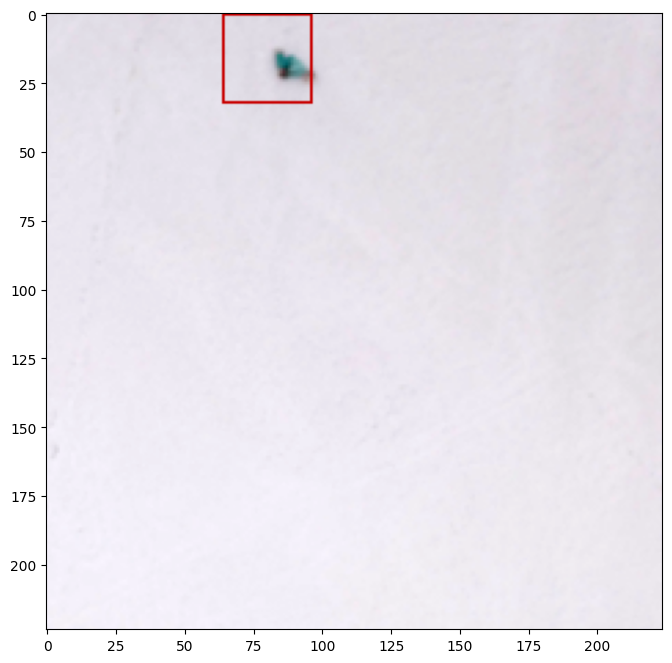

In [32]:
plt.figure(figsize=(8,8))

img_arr = sample[0]
y = sample[1].reshape((7,7))

img = tf.keras.utils.array_to_img(img_arr)
xy = np.array(np.where(y==1)).ravel()[::-1]
bb = np.array([xy, xy+1]).ravel() * 32

draw = ImageDraw.Draw(img)
draw.rectangle(bb.tolist(), outline=(200,0,0))
y_img = Image.fromarray(y*255)
y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))


plt.imshow(img)
plt.show()  

## Tflite inference 

In [49]:
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)

In [50]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [51]:
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(np.any(output_data > 0.1))

True


## Load Keras model

In [4]:
model = tf.keras.models.load_model(saved_model_dir, compile=False )

In [22]:
x, y = sample

In [40]:
model(np.expand_dims(x, 0))

<tf.Tensor: shape=(1, 7, 7, 1), dtype=float32, numpy=
array([[[[0.05792528],
         [0.05382237],
         [0.6408521 ],
         [0.20147687],
         [0.05509168],
         [0.01429811],
         [0.01676282]],

        [[0.02553678],
         [0.02059594],
         [0.05771407],
         [0.03339586],
         [0.00581059],
         [0.00592929],
         [0.0073967 ]],

        [[0.03009304],
         [0.0078609 ],
         [0.01039591],
         [0.00658906],
         [0.00623465],
         [0.00740761],
         [0.00835496]],

        [[0.01297015],
         [0.00661385],
         [0.00832328],
         [0.00898394],
         [0.00836447],
         [0.00870073],
         [0.00665769]],

        [[0.01210839],
         [0.00616866],
         [0.00713497],
         [0.00822389],
         [0.00768051],
         [0.00797933],
         [0.00780967]],

        [[0.00994065],
         [0.00660539],
         [0.00720942],
         [0.00758091],
         [0.00696796],
         [0.0091

In [3]:
# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"custom_loss":focal_loss}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(saved_model_dir, custom_objects=custom_objects, )

ValueError: Unknown loss function: focal_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
x